In [1]:

import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from echospec.utils.parameters import Parameters
from echospec.experiments.spectroscopy_vs_amplitude import AmplitudeSweepSpectroscopy, OptionsSpectroscopy2d
from echospec.utils.units import Units as u

from echospec.simulation.torry import find_fwhm_vec_vs_rabi

Amplitude sweep:   0%|          | 0/31 [00:00<?, ?Ω/s]

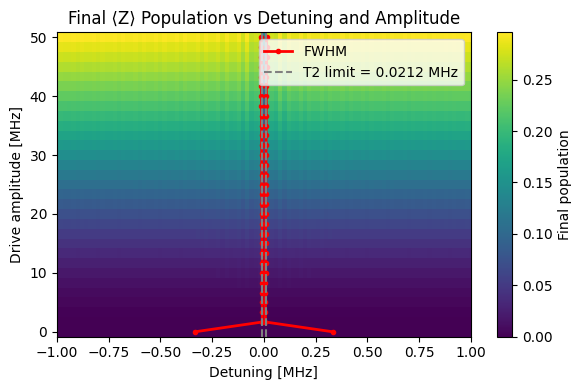

In [2]:
options = OptionsSpectroscopy2d(plot=True)
options.num_time_points = 5000
params = Parameters()
params.eco_pulse = True


detunings = np.linspace(-1, 1, 101)*2*np.pi*u.MHz
amplitudes = np.linspace(0, 50, 31)*2*np.pi*u.MHz
spectroscopy = AmplitudeSweepSpectroscopy(
    amplitudes=amplitudes,
    detunings=detunings,
    params=params,
    options=options
)

results = spectroscopy.run()

/var/folders/5l/mx_yndbx4sq978lx9ht2346r0000gn/T/ipykernel_98652/1496561954.py:37: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(amplitudes / (2 * np.pi * u.MHz), fwhm_values/T2_limit/snr_values*1e6*1.4, marker='.')


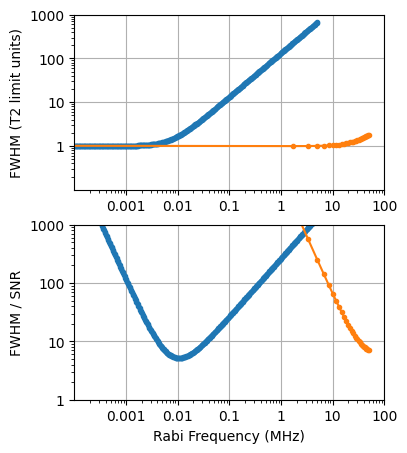

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(4, 5))


ws,fwhms,snrs = find_fwhm_vec_vs_rabi(
    T1=params.T1,
    T2=params.T2,
)

T1 = params.T1
T2 = params.T2

T2_limit= params.T2_limit


fwhm_values = spectroscopy.fwhm_values / (2 * np.pi * u.MHz)
snr_values = spectroscopy.snr_values


ax[0].plot(ws / (2 * np.pi * u.MHz), fwhms / T2_limit, marker='.')
ax[0].plot(amplitudes / (2 * np.pi * u.MHz), fwhm_values/T2_limit*1e6*1.4, marker='.')

ax[0].set_ylabel('FWHM (T2 limit units)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-1, 1e3)
ax[0].set_xlim(1e-4, 1e2)
ax[0].set_xticks([1e-3,1e-2, 1e-1, 1, 10, 100])
ax[0].set_xticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])

ax[0].set_yticks([1,10,100,1000])
ax[0].set_yticklabels(['1', '10', '100', '1000'])

ax[0].grid(True)


ax[1].plot(ws / (2 * np.pi * u.MHz), fwhms/T2_limit/snrs, marker='.')
ax[1].plot(amplitudes / (2 * np.pi * u.MHz), fwhm_values/T2_limit/snr_values*1e6*1.4, marker='.')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Rabi Frequency (MHz)')
ax[1].set_ylabel('FWHM / SNR')
ax[1].set_ylim(1e0, 1e3)
ax[1].set_xlim(1e-4, 1e2)
ax[1].set_xticks([1e-3,1e-2, 1e-1, 1, 10, 100])
ax[1].set_xticklabels(['0.001', '0.01', '0.1', '1', '10', '100'])

ax[1].set_yticks([1,10,100,1000])
ax[1].set_yticklabels(['1', '10', '100', '1000'])
ax[1].grid(True)

plt.tight_layout

plt.savefig('fwhm_vs_rabi.png', dpi=300)
